In [4]:
!pip3 install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 45.3 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


In [6]:
!pip3 install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 35.1 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [prophet]m4/5 [prophet]]

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, IsolationForest

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [15]:
df = pd.read_csv("/Users/kenilpatel/Downloads/archive/GlobalWeatherRepository.csv")
df.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [18]:
df['last_updated'] = pd.to_datetime(df['last_updated'])
df = df.sort_values('last_updated')
df = df.set_index('last_updated')

In [19]:
df = df.ffill().bfill()

In [21]:
def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[col] >= Q1 - 1.5*IQR) & (data[col] <= Q3 + 1.5*IQR)]

df = remove_outliers(df, 'temperature_celsius')

In [22]:
numeric_cols = df.select_dtypes(include=np.number).columns

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

/var/folders/6r/hz2dpx6157d1v7xv8f5g1b1h0000gn/T/ipykernel_7022/3262312211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


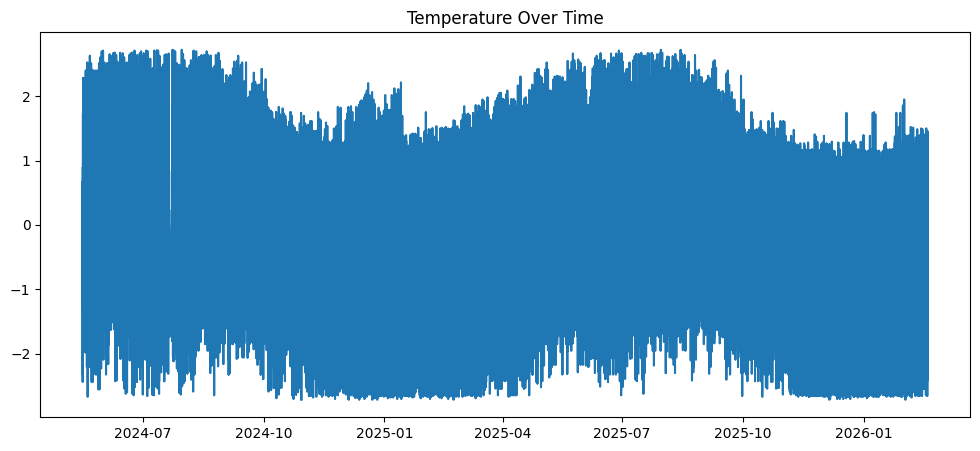

In [35]:
plt.figure(figsize=(12,5))
plt.plot(df['temperature_celsius'])
plt.title("Temperature Over Time")
plt.show()

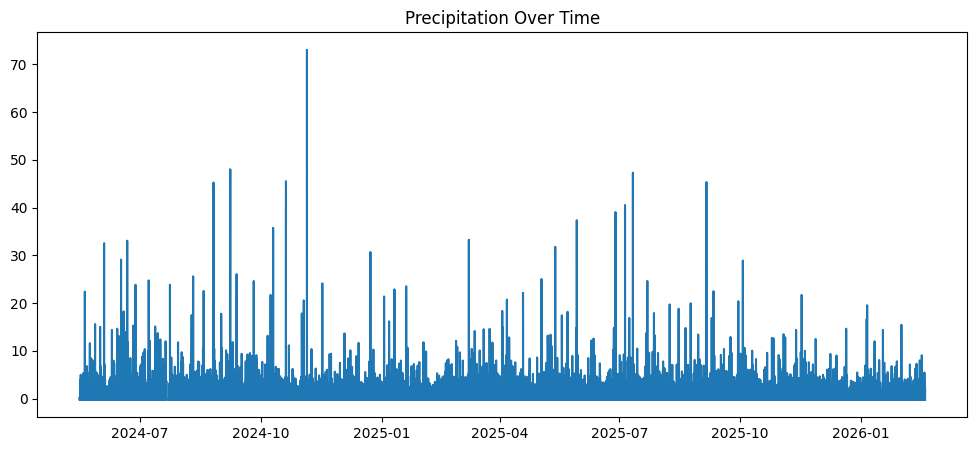

In [28]:
plt.figure(figsize=(12,5))
plt.plot(df['precip_mm'])
plt.title("Precipitation Over Time")
plt.show()

In [30]:
numeric_df = df.select_dtypes(include=['number'])

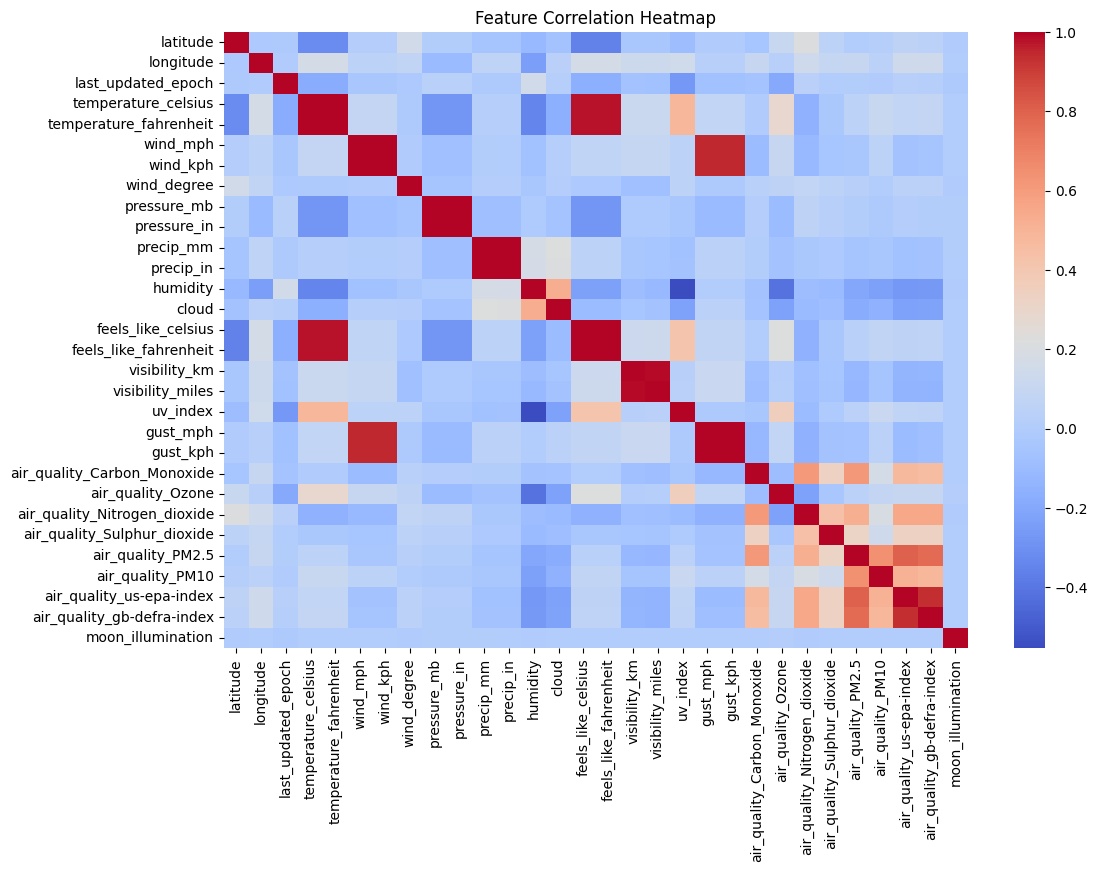

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

/var/folders/6r/hz2dpx6157d1v7xv8f5g1b1h0000gn/T/ipykernel_7022/1546826534.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['temperature_celsius'].resample('M').mean()


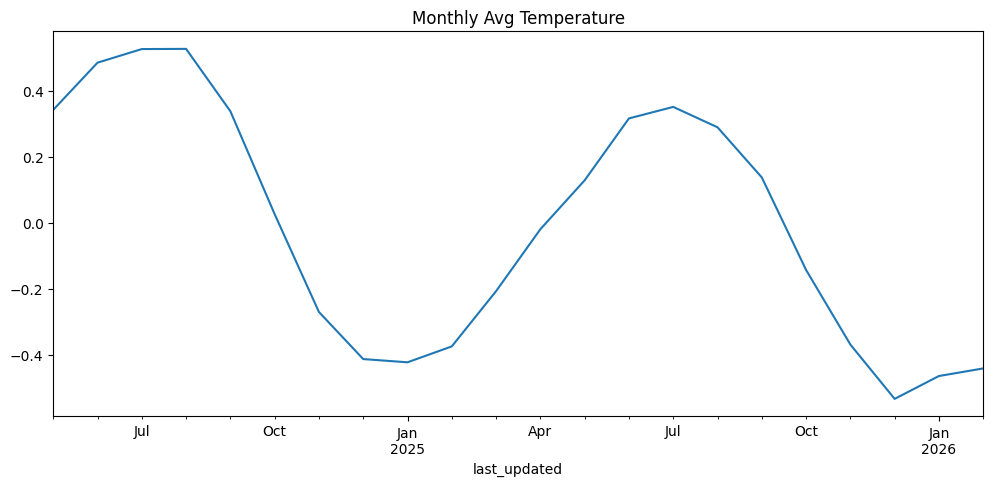

In [34]:
monthly_avg = df['temperature_celsius'].resample('M').mean()
monthly_avg.plot(figsize=(12,5), title="Monthly Avg Temperature")
plt.show()

In [36]:
train_size = int(len(df)*0.8)
train = df['temperature_celsius'][:train_size]
test = df['temperature_celsius'][train_size:]

In [37]:
model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,12))
sarima_fit = model.fit()

sarima_forecast = sarima_fit.forecast(len(test))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported

In [38]:
mae_sarima = mean_absolute_error(test, sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast))

print("SARIMA MAE:", mae_sarima)
print("SARIMA RMSE:", rmse_sarima)

SARIMA MAE: 0.88272442139084
SARIMA RMSE: 1.0315029860052891


In [40]:
prophet_df = df.reset_index()[['last_updated','temperature_celsius']]
prophet_df.columns = ['ds','y']

train_prophet = prophet_df[:train_size]
test_prophet = prophet_df[train_size:]

model = Prophet()
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

prophet_forecast = forecast['yhat'][-len(test):].values

13:46:26 - cmdstanpy - INFO - Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
mae_prophet = mean_absolute_error(test_prophet['y'], prophet_forecast)
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], prophet_forecast))

print("Prophet MAE:", mae_prophet)
print("Prophet RMSE:", rmse_prophet)

Prophet MAE: 38.72845856402667
Prophet RMSE: 44.753557526214564


In [42]:
comparison = pd.DataFrame({
    "Model": ["SARIMA","Prophet"],
    "MAE": [mae_sarima, mae_prophet],
    "RMSE": [rmse_sarima, rmse_prophet]
})
comparison

,Model,MAE,RMSE
0,SARIMA,0.882724,1.031503
1,Prophet,38.728459,44.753558


In [44]:
features = df[['temperature_celsius','humidity','pressure_mb']]

iso = IsolationForest(contamination=0.01)
df['anomaly'] = iso.fit_predict(features)

anomalies = df[df['anomaly']==-1]

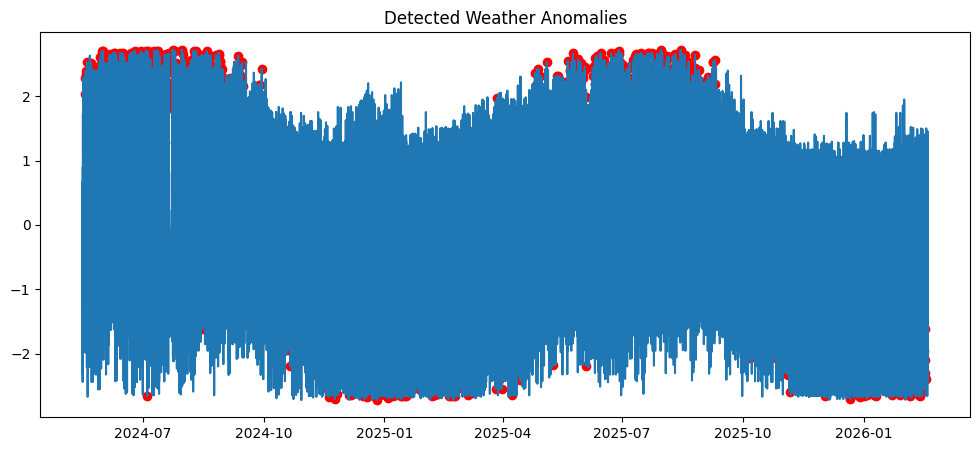

In [46]:
plt.figure(figsize=(12,5))
plt.plot(df['temperature_celsius'])
plt.scatter(anomalies.index, anomalies['temperature_celsius'], color='red')
plt.title("Detected Weather Anomalies")
plt.show()

In [48]:
numeric_df = df.select_dtypes(include=['number'])

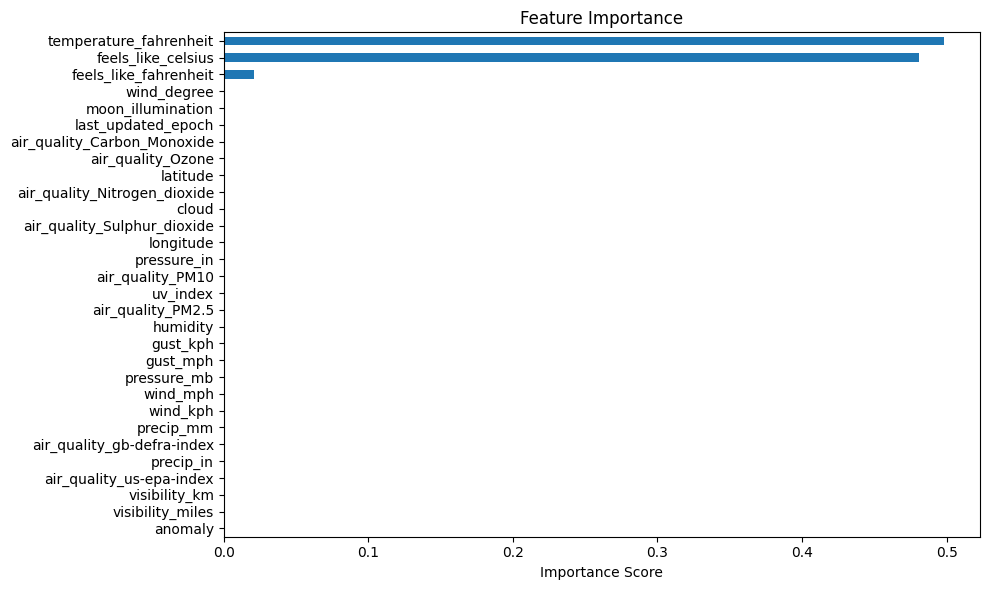

In [52]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣ Keep only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# 2️⃣ Define features and target
X = numeric_df.drop(columns=['temperature_celsius'])
y = numeric_df['temperature_celsius']

# 3️⃣ Train Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# 4️⃣ Get feature importance
importance = pd.Series(rf.feature_importances_, index=X.columns)

# 5️⃣ Plot sorted importance
importance.sort_values().plot(kind='barh', figsize=(10,6))
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [53]:
df.groupby('country')['temperature_celsius'].std().sort_values().head()

country
Kiribati            0.076085
Cote d'Ivoire       0.092057
Maldives            0.094999
Marshall Islands    0.101602
Tuvalu              0.108739
Name: temperature_celsius, dtype: float64